In [100]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.decomposition import PCA
from sklearn.feature_selection import VarianceThreshold
from sklearn.neighbors import KNeighborsClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score
from sklearn.metrics import f1_score
from sklearn.pipeline import make_pipeline

from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.preprocessing import MinMaxScaler, StandardScaler
import numpy as np
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans, AgglomerativeClustering
from sklearn.preprocessing import StandardScaler
from scipy.cluster.hierarchy import dendrogram, linkage
import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.cluster import KMeans, AgglomerativeClustering, DBSCAN
from sklearn.preprocessing import StandardScaler




In [109]:
data = pd.read_csv("data/CATSnDOGS.csv")
labels = pd.read_csv("data/labels.csv")

Some pre-processing, ex find number of PC for kNN ans such

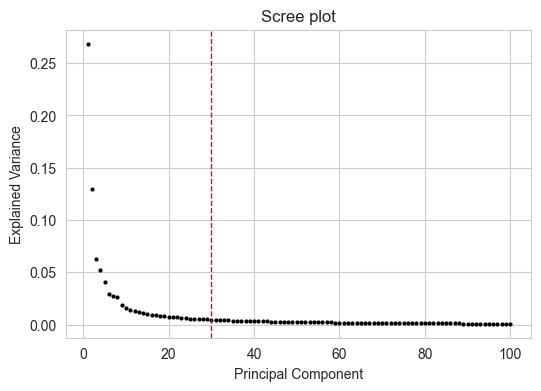

In [11]:
# This should maybe only be done for training data
train_data, test_data, train_labels, test_labels = train_test_split(data, labels, test_size=0.2, random_state=42)

trainX_pp = StandardScaler().fit_transform(train_data)
train_data_pca = PCA().fit(trainX_pp)
principal_components_pca = train_data_pca.transform(trainX_pp)

# Plot the importance of the principal components
fig = plt.figure(figsize=(6, 4))
ax = fig.gca()

num_components_to_plot = min(100, len(train_data_pca.explained_variance_ratio_))
ax.plot(np.arange(1, num_components_to_plot + 1), train_data_pca.explained_variance_ratio_[:num_components_to_plot], 'ok', markersize=2)
ax.axvline(30, linestyle="dashed", color="red", linewidth=1)
plt.title('Scree plot')
ax.set_xlabel("Principal Component")
ax.set_ylabel("Explained Variance")
plt.show()

In [75]:
#Top 30 PC looks reasonable 
num_principal_components = 30
num_tests = 50
pca = PCA(n_components=num_principal_components)
scaler = StandardScaler()



knn_flexible_scores = []
knn_rigid_scores = []
random_forest_scores = []
# LDA_scores = []
log_reg_scores = []
svm_scores = []

log_reg_models = []
svm_models = []

for i in range(num_tests):
    
    #Initialize classifiers
    knn_classifier_flexible = KNeighborsClassifier(n_neighbors=3)
    knn_classifier_rigid = KNeighborsClassifier(n_neighbors=50)
    random_forest = RandomForestClassifier(n_estimators=50, n_jobs=-1)
    # LDA = LinearDiscriminantAnalysis()
    log_reg = LogisticRegression()
    svm_classifier = SVC(kernel='linear')  # Linear kernel for linear SVM
    
    train_data, test_data, train_labels, test_labels = train_test_split(data, labels, test_size=0.4, shuffle=True)
    
    # Fit the scaler on the training data and transform the training data
    train_data_scaled = scaler.fit_transform(train_data)
    
    # Transform the test data using the already fitted scaler
    test_data_scaled = scaler.transform(test_data)
    
    #X_train_pca = pca.fit_transform(train_data_scaled)
    #X_test_pca = pca.transform(test_data_scaled)
    
    # Evaluate flexible KNN classifier
    knn_classifier_flexible.fit(train_data_scaled, train_labels.values.ravel())
    scores_knn_flexible = accuracy_score(test_labels.values.ravel(), knn_classifier_flexible.predict(test_data_scaled))
    knn_flexible_scores.append(scores_knn_flexible)
    
    # Evaluate rigid KNN classifier
    knn_classifier_rigid.fit(train_data_scaled, train_labels.values.ravel())
    scores_knn_rigid = accuracy_score(test_labels.values.ravel(), knn_classifier_rigid.predict(test_data_scaled))
    knn_rigid_scores.append(scores_knn_rigid)
    
    # Evaluate Random Forest 
    random_forest.fit(train_data, train_labels.values.ravel())
    rf_test_accuracy = accuracy_score(test_labels.values.ravel(), random_forest.predict(test_data))
    random_forest_scores.append(rf_test_accuracy)
    
    #Evaluate Linear Discriminant Analysis
    # LDA.fit(train_data, train_labels.values.ravel())
    # LDA_test_accuracy = accuracy_score(test_labels.values.ravel(), LDA.predict(test_data))
    # LDA_scores.append(LDA_test_accuracy)
    
    # Evaluate Logistic Regression
    log_reg.fit(train_data, train_labels.values.ravel())
    log_reg_test_accuracy = accuracy_score(test_labels.values.ravel(), log_reg.predict(test_data))
    log_reg_scores.append(log_reg_test_accuracy)
    
    # Fit and evaluate the SVM classifier
    svm_classifier.fit(train_data, train_labels.values.ravel())
    scores_svm = accuracy_score(test_labels.values.ravel(), svm_classifier.predict(test_data))
    svm_scores.append(scores_svm)
    
    # save every fitted model to be able to extract feature importance from multiple varaints of the same model
    log_reg_models.append(log_reg)
    svm_models.append(svm_classifier)
        
    
    
    
print("Test scores for the test set size 40% ")
print('KNN flexible scores:', np.mean(knn_flexible_scores))
print('KNN rigid scores:', np.mean(knn_rigid_scores))
print('Random forest scores:', np.mean(random_forest_scores))
# print('LDA scores:', np.mean(LDA_scores))
print('Logistic regression scores:', np.mean(log_reg_scores))
print('SVM scores:', np.mean(svm_scores))

Test scores for the test set size 40% 
KNN flexible scores: 0.757
KNN rigid scores: 0.6679999999999999
Random forest scores: 0.74375
Logistic regression scores: 0.7615
SVM scores: 0.7457499999999999


In [ ]:
from sklearn.inspection import permutation_importance
# Feature importance using permutation importance
result = permutation_importance(knn_classifier_flexible, test_data_scaled, test_labels, n_repeats=10, random_state=42, n_jobs=-1)

Feature Importance: (4096,)
Feature Importance: (4096,)


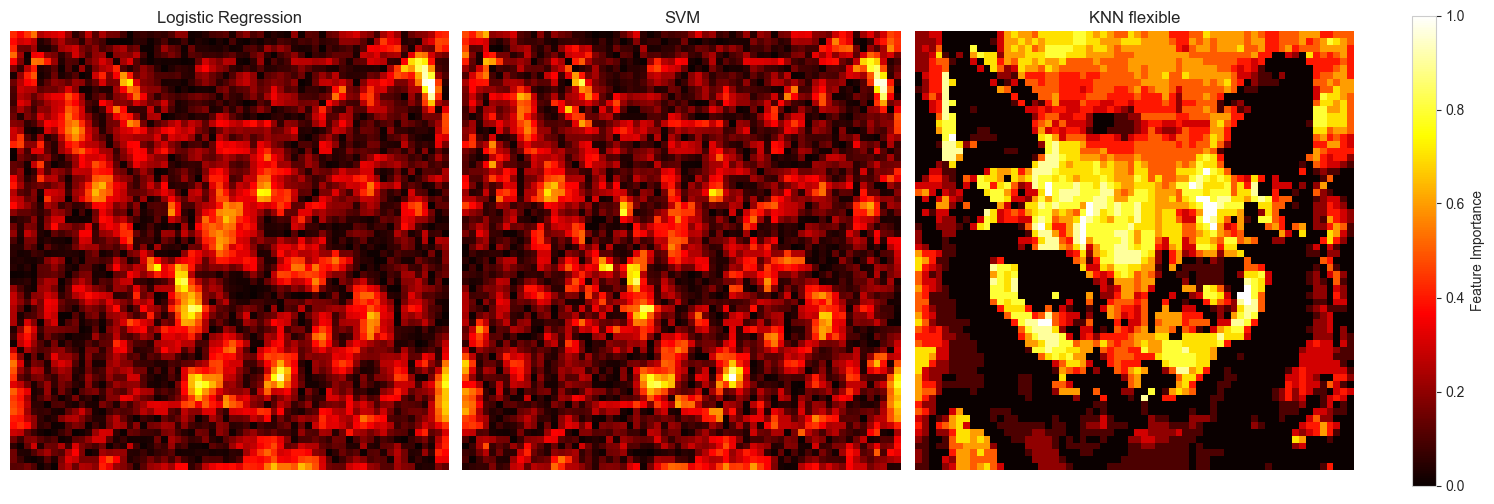

In [86]:
# LOgistic regression
# start a figure with a subplot with one rows and three column
fig, ax = plt.subplots(1, 3, figsize=(15, 5))
importances = np.zeros(4096)
for log_reg in log_reg_models:
    # Feature importance
    importance = log_reg.coef_[0]
    importances += importance
    # Rescale importance to be between 0 and 1
importance = np.abs(importances) / np.max(np.abs(importances))
# set values below threshold to zero
#importance[importance < 0.4] = 0
image = importance.reshape(-1, 64, 64).transpose(0, 2, 1).squeeze()
print("Feature Importance:", importance.shape)
ax[0].imshow(image, cmap='hot')
ax[0].set_title('Logistic Regression')
ax[0].axis('off')
# store features with importance above threshold 0.4
# imp_features = np.where(importance > 0.4)[0]

# SVM
importances = np.zeros(4096)
for svm_classifier in svm_models:
    # Feature importance
    importance = svm_classifier.coef_[0]
    importances += importance
    # Rescale importance to be between 0 and 1
importances = np.abs(importances) / np.max(np.abs(importances))
# set values below threshold to zero
#importance[importance < 0.4] = 0
image = importances.reshape(-1, 64, 64).transpose(0, 2, 1).squeeze()
print("Feature Importance:", importances.shape)
ax[1].imshow(image, cmap='hot')
ax[1].set_title('SVM')
ax[1].axis('off')

# store features with importance above threshold 0.4
# imp_features = np.where(importance > 0.4)[0]

# KNN
importance = result.importances_mean
# Feature importance
#importance = svm_classifier.coef_[0]
# Rescale importance to be between 0 and 1
importance = np.abs(importance) / np.max(np.abs(importance))
# set values below threshold to zero
#importance[importance < 0.2] = 0
image = importance.reshape(-1, 64, 64).transpose(0, 2, 1).squeeze()
ax[2].imshow(image, cmap='hot')
ax[2].set_title('KNN flexible')
ax[2].axis('off')
fig.tight_layout()
# add colorbar
cbar = fig.colorbar(ax[2].imshow(image, cmap='hot'), ax=ax, orientation='vertical', fraction=0.046, pad=0.04)
cbar.set_label('Feature Importance')

plt.show()


In [92]:
X_scaled = train_data_scaled.copy()

In [101]:
# Reduce dimensionality with PCA
pca = PCA(n_components=50)  # Adjust the number of components as needed
X_pca = pca.fit_transform(X_scaled)

print("Explained variance ratio:", pca.explained_variance_ratio_)
print("Cumulative explained variance:", np.cumsum(pca.explained_variance_ratio_))


Explained variance ratio: [0.24351533 0.13463852 0.06613684 0.05460044 0.04515121 0.03066912
 0.02731576 0.02565511 0.02012881 0.01906845 0.0159597  0.01420034
 0.01366741 0.01272029 0.01195542 0.01150722 0.00986299 0.00915074
 0.00896343 0.00860198 0.00811588 0.00788577 0.00751398 0.00716051
 0.00653442 0.0063955  0.0059118  0.00563263 0.00550703 0.00542487
 0.00501949 0.00480155 0.00456526 0.00435755 0.00420673 0.00411436
 0.003872   0.00382003 0.00374599 0.0036684  0.0034214  0.00332287
 0.00316495 0.00298158 0.00289439 0.00276077 0.00270105 0.00267317
 0.00256957 0.00249356]
Cumulative explained variance: [0.24351533 0.37815386 0.4442907  0.49889114 0.54404234 0.57471147
 0.60202723 0.62768233 0.64781114 0.6668796  0.68283929 0.69703963
 0.71070704 0.72342733 0.73538275 0.74688997 0.75675296 0.7659037
 0.77486713 0.78346912 0.791585   0.79947077 0.80698475 0.81414526
 0.82067967 0.82707517 0.83298697 0.8386196  0.84412663 0.8495515
 0.85457099 0.85937255 0.86393781 0.86829536 0.872

In [113]:
y = np.array([train_labels[key] for key in sorted(train_labels.keys())])

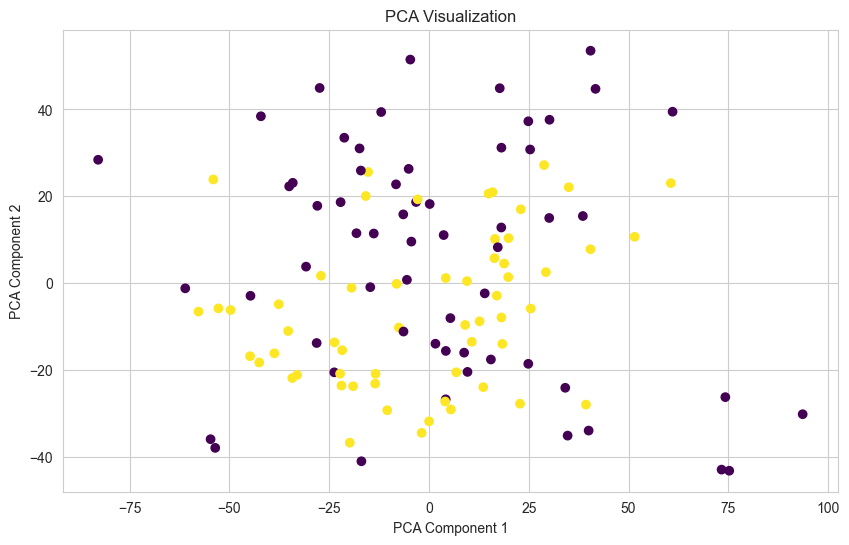

In [116]:
# Plot two PCA components scatter with labels
plt.figure(figsize=(10, 6))
plt.scatter(X_pca[:, 0], X_pca[:, 1], c=y, cmap='viridis')
plt.xlabel('PCA Component 1')
plt.ylabel('PCA Component 2')
plt.title('PCA Visualization')
plt.show()

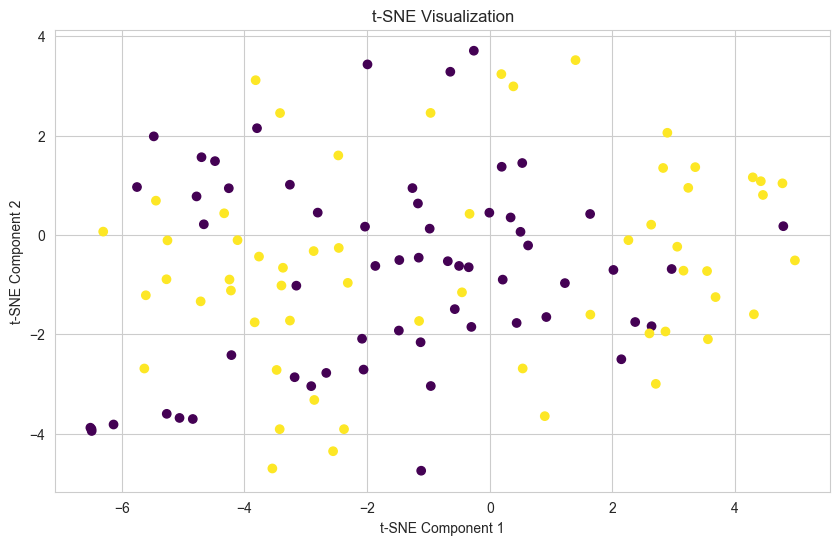

In [119]:
# Reduce dimensionality with t-SNE
tsne = TSNE(n_components=2, random_state=42)
X_tsne = tsne.fit_transform(X_scaled)  # Use PCA-reduced data as input

plt.figure(figsize=(10, 6))
plt.scatter(X_tsne[:, 0], X_tsne[:, 1], c=y, cmap='viridis')
plt.xlabel('t-SNE Component 1')
plt.ylabel('t-SNE Component 2')
plt.title('t-SNE Visualization')
plt.show()


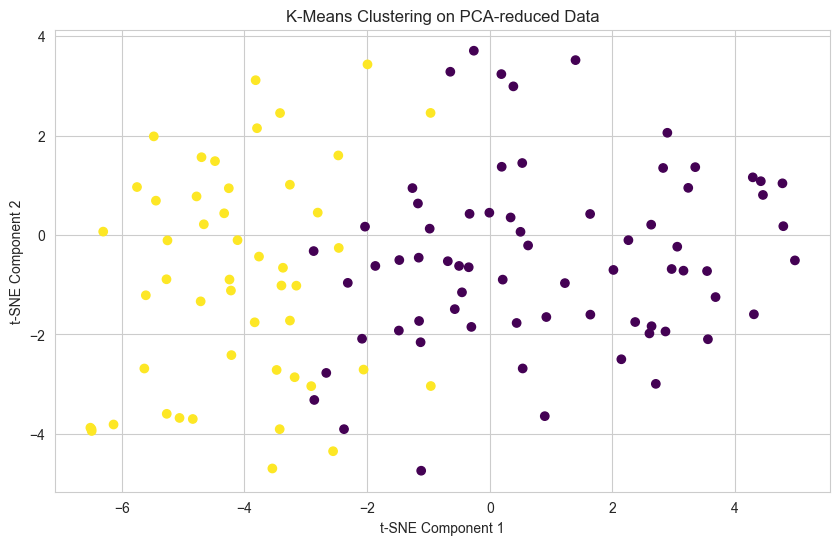

In [120]:
# K-Means Clustering on PCA-reduced data
kmeans = KMeans(n_clusters=2, random_state=42)
kmeans_labels = kmeans.fit_predict(X_pca)

plt.figure(figsize=(10, 6))
plt.scatter(X_tsne[:, 0], X_tsne[:, 1], c=kmeans_labels, cmap='viridis')
plt.xlabel('t-SNE Component 1')
plt.ylabel('t-SNE Component 2')
plt.title('K-Means Clustering on PCA-reduced Data')
plt.show()
